In [241]:
import pandas as pd
import numpy as np
import math
from scipy.stats import describe, randint
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns


sns.set()


# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

# 3.

In [602]:
def random_neighbour(point):

    # Getting dimension
    dimension = len(point)
    
    # Generate if going up or down
    up_or_down = 2*np.random.randint(2, size=1)[0] - 1
    
    # Generate which diretion to go in
    direction = np.random.randint(dimension, size=1)[0]
    
    # Create new point
    new_point = point.copy()
    new_point[direction]+= up_or_down
    
    return new_point

def is_self_avoiding(random_walks, weights):
    
    is_saw = lambda x: 1 if(weights != 0 and len(np.unique(x, axis=0)) == len(x)) else 0

    l = len(random_walks[0])
    array_of_saw = [0] * l
    for index in range(l):
        particle = [item[index] for item in random_walks]
        array_of_saw[index] = is_saw(particle)
    return array_of_saw      

def init_walk (d, k, N):
    random_walks = []
    weights = [[1] * N]
    pos = [[0]*d]*N
    random_walks.append(pos)
    for step in range(k):
        step_all = list(map(random_neighbour, random_walks[step]))
        random_walks.append(step_all)
        weights.append(is_self_avoiding(random_walks, weights[step]))
        print(step)
    return random_walks, weights

In [603]:
walks, weights = init_walk(2,50,50000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [604]:
prob = []
for row in weights:
    prob.append(np.mean(row))

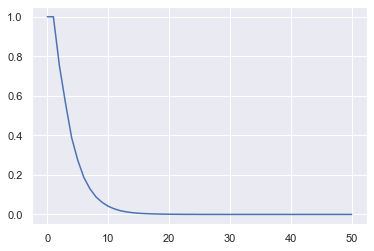

In [605]:
plt.plot(range(len(weights)), prob)